Found 7697 images belonging to 355 classes.
Found 3560 images belonging to 355 classes.
Epoch 1/750
240/240 [==============================] - 114s 450ms/step - loss: 5.6495 - accuracy: 0.0326 - val_loss: 5.1454 - val_accuracy: 0.0774
Epoch 2/750
240/240 [==============================] - 96s 401ms/step - loss: 4.7094 - accuracy: 0.1350 - val_loss: 4.2558 - val_accuracy: 0.1968
Epoch 3/750
240/240 [==============================] - 102s 425ms/step - loss: 3.8205 - accuracy: 0.2635 - val_loss: 3.5095 - val_accuracy: 0.2801
Epoch 4/750
240/240 [==============================] - 97s 405ms/step - loss: 3.1194 - accuracy: 0.3562 - val_loss: 2.9955 - val_accuracy: 0.3539
Epoch 5/750
240/240 [==============================] - 95s 395ms/step - loss: 2.6418 - accuracy: 0.4202 - val_loss: 2.6694 - val_accuracy: 0.3820
Epoch 6/750
240/240 [==============================] - 95s 397ms/step - loss: 2.3066 - accuracy: 0.4890 - val_loss: 2.4319 - val_accuracy: 0.4271
Epoch 7/750
240/240 [=============

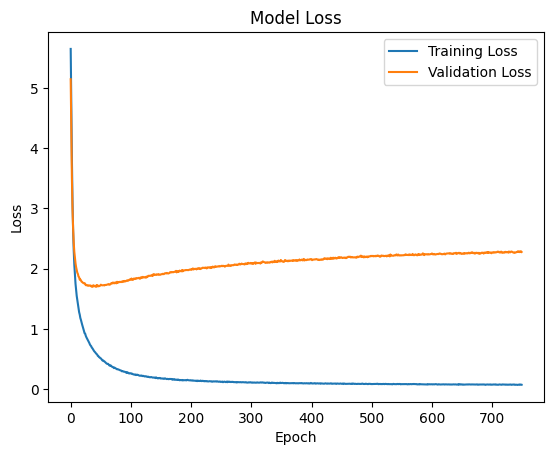

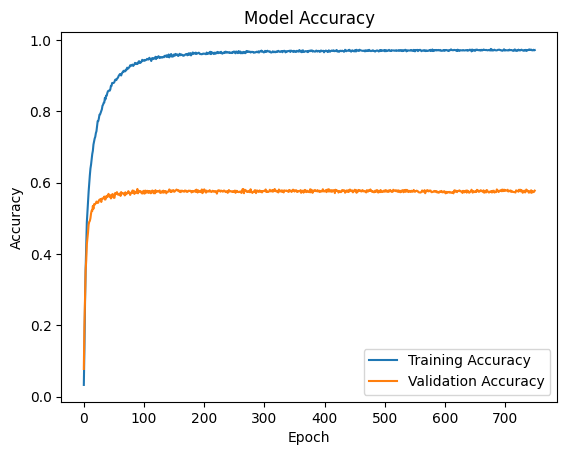

112/112 [==============================] - 19s 158ms/step
Accuracy: 0.5775280898876405
Average Precision: 0.5973143144718829
Average Recall: 0.5746200434932829
Average F1 Score: 0.5696781667474585


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import DenseNet121

# Define data directories
train_data_dir = r"C:\Users\79894\Downloads\archive2_converted_train"
test_data_dir = r"C:\Users\79894\Downloads\archive2_converted_test"

# Define data generators with preprocessing_function (fixed image size)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of preprocessed images
batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),  # Adjusted to match the DenseNet model input shape
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),  # Adjusted to match the DenseNet model input shape
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load pre-trained DenseNet model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of DenseNet
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(355, activation='softmax')(x)  # Adjust output neurons based on your classification task

# Combine base model and custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=SGD(learning_rate=1e-3, momentum=0.9, nesterov=True),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train your model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=750,  # Adjust as needed
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Extract results from the final epoch
final_epoch_results = {
    'loss': history.history['loss'][-1],
    'accuracy': history.history['accuracy'][-1],
    'val_loss': history.history['val_loss'][-1],
    'val_accuracy': history.history['val_accuracy'][-1]
}

# Print the final epoch results
print("Final Epoch Results:")
print(final_epoch_results)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot accuracy history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Evaluate the model on test data
validation_generator.reset()  # Reset the generator to start from the beginning
predictions = model.predict(validation_generator, steps=validation_generator.samples // batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(validation_generator.classes, predicted_classes)

# Calculate metrics
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)

precision = []
recall = []
f1_score = []

for i in range(355):  # Adjusted based on the number of classes
    true_positives = conf_matrix[i, i]
    false_positives = np.sum(conf_matrix[:, i]) - true_positives
    false_negatives = np.sum(conf_matrix[i, :]) - true_positives

    precision_i = true_positives / (true_positives + false_positives) if true_positives + false_positives != 0 else 0
    recall_i = true_positives / (true_positives + false_negatives) if true_positives + false_negatives != 0 else 0

    precision.append(precision_i)
    recall.append(recall_i)

    # Calculate F1 score
    if precision_i + recall_i != 0:
        f1_score_i = 2 * (precision_i * recall_i) / (precision_i + recall_i)
    else:
        f1_score_i = 0

    f1_score.append(f1_score_i)

# Calculate average precision, recall, and F1 score
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1_score = np.mean(f1_score)

# Print the metrics
print("Accuracy:", accuracy)
print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1 Score:", avg_f1_score)
